<a href="https://colab.research.google.com/github/riddhima-biswas/SkincancerDetection/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.
Epoch 1/100
2/2 - 20s - 10s/step - loss: 0.2521
Epoch 2/100
2/2 - 9s - 4s/step - loss: 0.2050
Epoch 3/100
2/2 - 7s - 4s/step - loss: 0.1767
Epoch 4/100
2/2 - 9s - 4s/step - loss: 0.1430
Epoch 5/100
2/2 - 8s - 4s/step - loss: 0.1211
Epoch 6/100
2/2 - 8s - 4s/step - loss: 0.1132
Epoch 7/100
2/2 - 8s - 4s/step - loss: 0.1029
Epoch 8/100
2/2 - 7s - 4s/step - loss: 0.0861
Epoch 9/100
2/2 - 9s - 4s/step - loss: 0.0752
Epoch 10/100
2/2 - 7s - 3s/step - loss: 0.0639
Epoch 11/100
2/2 - 9s - 4s/step - loss: 0.0520
Epoch 12/100
2/2 - 7s - 3s/step - loss: 0.0407
Epoch 13/100
2/2 - 9s - 4s/step - loss: 0.0225
Epoch 14/100
2/2 - 7s - 3s/step - loss: 0.0202
Epoch 15/100
2/2 - 9s - 4s/step - loss: 0.0077
Epoch 16/100
2/2 - 7s - 4s/step - loss: 0.0056
Epoch 17/100
2/2 - 9s - 4s/step - loss: -1.1653e-03
Epoch 18/100
2/2 - 8s - 4s/step - loss: -1.2091e-02
Epoch 19/100
2/2 - 8s - 4s/step - loss: -1.0512e-02
Epoch 20/100
2/2 - 8s

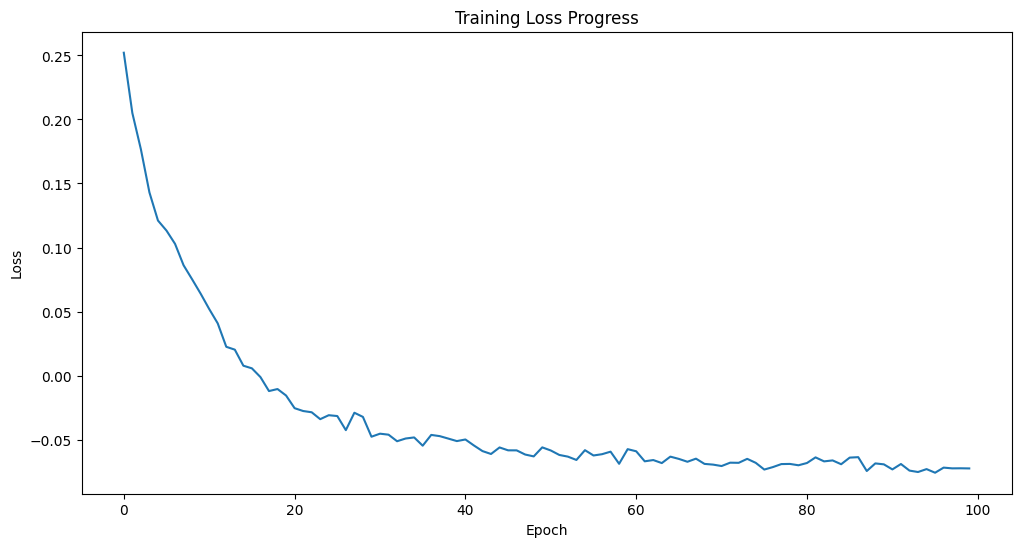


Final Training Loss: -0.07249829918146133


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from joblib import Parallel, delayed
import math
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_laplace
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from tensorflow.image import ssim_multiscale
from tensorflow.nn import conv2d
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer
from keras.initializers import Initializer
from keras.saving import register_keras_serializable


class GELULayer(Layer):
    """Approximate GELU implementation matching MATLAB version"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return 0.5 * inputs * (1 + tf.tanh(
            tf.sqrt(2 / np.pi) * (inputs + 0.044715 * tf.pow(inputs, 3))
        ))

class SwishLayer(Layer):
    """Swish activation with beta parameter"""
    def __init__(self, beta, **kwargs):
        super().__init__(**kwargs)
        self.beta = tf.constant(beta, dtype=tf.float32)

    def call(self, inputs):
        return inputs * tf.nn.sigmoid(self.beta * inputs)

    def get_config(self):
        config = super().get_config()
        config.update({'beta': self.beta.numpy()})
        return config

class FixedPReLULayer(Layer):
    """PReLU with fixed alpha (non-trainable)"""
    def __init__(self, alpha, **kwargs):
        super().__init__(**kwargs)
        self.alpha = tf.constant(alpha, dtype=tf.float32)

    def call(self, inputs):
        return tf.maximum(0.0, inputs) + self.alpha * tf.minimum(0.0, inputs)

    def get_config(self):
        config = super().get_config()
        config.update({'alpha': self.alpha.numpy()})
        return config


class CustomLoss(Loss):
    def __init__(self, alpha, beta, lambda_edge, lambda_noise, lambda_entropy):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.lambda_edge = lambda_edge
        self.lambda_noise = lambda_noise
        self.lambda_entropy = lambda_entropy

    def call(self, y_true, y_pred):
        y_true = tf.where(tf.math.is_nan(y_true), tf.ones_like(y_true), y_true)
        y_pred = tf.where(tf.math.is_nan(y_pred), tf.ones_like(y_pred), y_pred)
        y_true = tf.where(tf.equal(y_true, -np.inf), tf.zeros_like(y_true), y_true)
        y_true = tf.where(tf.equal(y_true, np.inf), tf.ones_like(y_true), y_true)
        y_pred = tf.where(tf.equal(y_pred, -np.inf), tf.zeros_like(y_pred), y_pred)
        y_pred = tf.where(tf.equal(y_pred, np.inf), tf.ones_like(y_pred), y_pred)
        invalid_mask_true = tf.math.logical_or(tf.math.is_nan(y_true), tf.math.is_inf(y_true))
        invalid_mask_pred = tf.math.logical_or(tf.math.is_nan(y_pred), tf.math.is_inf(y_pred))
        has_invalid = tf.reduce_any(tf.logical_or(invalid_mask_true, invalid_mask_pred))
        y_true = tf.clip_by_value(y_true, 0.0, 1.0)
        y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        nrmse = self.compute_nrmse(y_true, y_pred)
        msssim = self.compute_msssim(y_true, y_pred)
        edge_strength = tf.stop_gradient(self.compute_edge_strength(y_pred))
        noise_level = tf.stop_gradient(self.compute_noise_level(y_pred))
        entropy = tf.stop_gradient(self.compute_entropy(y_pred))
        loss = (self.alpha * nrmse +
                self.beta * msssim -
                self.lambda_entropy * entropy -
                self.lambda_edge * edge_strength +
                self.lambda_noise * noise_level)

        penalty = tf.cond(
            has_invalid,
            lambda: tf.constant(100, dtype=tf.float32),
            lambda: tf.constant(0.0, dtype=tf.float32)
        )
        return loss + penalty

    def compute_nrmse(self, y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        value_range = tf.reduce_max(y_true) - tf.reduce_min(y_true)
        return tf.sqrt(mse) / (value_range + tf.keras.backend.epsilon())

    def compute_msssim(self, y_true, y_pred):
          ms_ssim_value = tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0)
          mean_msssim = tf.reduce_mean(ms_ssim_value)
          return 1.0 - mean_msssim
    def compute_edge_strength(self, images):
        sobel_x = tf.image.sobel_edges(images)[..., 0]
        sobel_y = tf.image.sobel_edges(images)[..., 1]
        grad_mag = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
        mean_grad = tf.reduce_mean(grad_mag, axis=[1, 2], keepdims=True)
        std_grad = tf.math.reduce_std(grad_mag, axis=[1, 2], keepdims=True)
        threshold = mean_grad / (std_grad + 1e-6)
        weighted_grad = grad_mag / (1 + tf.exp(-10 * (grad_mag - threshold)))
        return tf.reduce_mean(weighted_grad)

    def compute_noise_level(self, images):
        kernel = tf.ones((3, 3, 1, 1)) / 9.0
        local_mean = conv2d(images, kernel, strides=1, padding='SAME')
        local_var = conv2d(tf.square(images), kernel, strides=1, padding='SAME') - tf.square(local_mean)
        return tf.reduce_mean(tf.abs(local_var))

    def compute_entropy(self, images):
        num_bins = 256
        sigma = 0.01
        bin_centers = tf.reshape(tf.linspace(0.0, 1.0, num_bins), [1, 1, 1, num_bins])
        diff = tf.expand_dims(images, -1) - bin_centers
        hist = tf.reduce_sum(tf.exp(-tf.square(diff) / (2 * sigma**2)), axis=[1, 2])
        hist = hist / (tf.reduce_sum(hist, axis=-1, keepdims=True) + 1e-12)
        entropy = -tf.reduce_sum(hist * tf.math.log(hist + 1e-12), axis=-1)
        return tf.reduce_mean(entropy)


# Custom filter generation functions
def generate_lap(n):
    """Python implementation of MATLAB generateLap function"""
    r = np.random.rand()
    q = (n + 1) // 2
    M = np.zeros((q, q))

    if r <= 0.5:
        for i in range(q):
          for j in range(q-i-1, q):
              M[i, j] = i + j-q+2
    else:
        for i in range(q):
            for j in range(q):
                M[i, j] = min(i+1, j+1)

    M = np.block([[M, np.fliplr(M)],
                  [np.flipud(M), np.flipud(np.fliplr(M))]])

    if n % 2 == 1:
        M = np.delete(M, q-1, 0)
        M = np.delete(M, q-1, 1)
        M[q-1,q-1] = 0
        total = np.sum(M)
        M[q-1, q-1] = -total
    else:
        M[q-1:q+1, q-1:q+1] = 0
        total = np.sum(M)
        M[q-1:q+1, q-1:q+1] = -total / 4

    return M.astype(np.float32)

def sobel_prewitt_filter(n):
    """Python implementation of MATLAB sobelprewittFilter"""
    q = (n + 1) // 2
    X, Y = np.meshgrid(np.arange(n), np.arange(n))
    if np.random.rand() <= 0.5:
        M = np.zeros((q, q))
        for i in range(q):
            for j in range(q):
                M[i, j] = i + j

        # print(M)
        M = np.block([[M, np.fliplr(M)],
                      [np.flipud(M), np.flipud(np.fliplr(M))]])

        if n % 2 == 1:
            M = np.delete(M, q-1, 0)
            M = np.delete(M, q-1, 1)
            M[:, q-1] = 0
            kernel = np.sign(X - q+1) * (2 ** M)
        else:
            kernel = np.sign(X - q+0.000001) * (2 ** M)
    else:
        kernel = np.sign(X - q + 1).astype(np.float32)
        if n % 2 == 0:
          kernel[:,q-1]=-1

    if np.random.rand() <= 0.5:
        kernel = kernel.T

    return kernel


def create_gabor_filter(n, lambd, theta, sigma, gamma):
    """Python implementation of MATLAB createGaborFilter"""
    if n % 2 == 1:
        grid = np.arange(-n//2 + 1, n//2 + 1)
    else:
        grid = np.linspace(-n/2 + 0.5, n/2 - 0.5, n)

    x, y = np.meshgrid(grid, grid)
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gabor = np.exp(-(x_theta**2 + gamma**2 * y_theta**2) / (2 * sigma**2))
    gabor *= np.cos(2 * np.pi * x_theta / lambd)

    return gabor.astype(np.float32)

def create_scharr_filter():
    """Python implementation of MATLAB createScharrFilter"""
    M = np.array([[-3, 0, 3],
                  [-10, 0, 10],
                  [-3, 0, 3]], dtype=np.float32)
    if np.random.rand() <= 0.5:
        return M.T
    return M

def fspecial_log(n, sigma):
    siz = (n - 1) / 2
    x = np.arange(-siz, siz + 1)
    y = x[:, np.newaxis]
    std2 = sigma ** 2
    arg = -(x**2 + y**2) / (2 * std2)
    h = np.exp(arg)
    h[h < np.finfo(float).eps * h.max()] = 0
    if h.sum() != 0:
        h /= h.sum()
    h1 = h * (x**2 + y**2 - 2 * std2) / (std2 ** 2)
    h = h1 - h1.mean()
    return h.astype(np.float32)

def filterselection(t, s, n, ni):
    """Python equivalent of MATLAB filterselection function with Keras initializer handling"""
    s = int(s)
    n = int(n)
    ni = int(ni)
    t=int(t)
    if t == 0:  # Average filter
        kernel = np.ones((s, s)) / (s**2)
        return np.tile(kernel[:, :, np.newaxis, np.newaxis], (1, 1, ni, n))

    elif t == 1:  # Gaussian
        filters = []
        for _ in range(n):
            sigma = s/6 + np.random.rand()
            kernel = cv2.getGaussianKernel(s, sigma)
            kernel = kernel @ kernel.T
            filters.append(np.repeat(kernel[:, :, np.newaxis], ni, axis=2))
        return np.stack(filters, axis=3)

    elif t == 2:  # Double Gaussian
        filters = []
        for _ in range(n):
            sigma = s/6 + np.random.rand()
            kernel = cv2.getGaussianKernel(s, sigma)
            kernel = kernel @ kernel.T
            kernel= convolve2d(kernel, kernel, mode='same', boundary='symm')
            filters.append(np.repeat(kernel[:, :, np.newaxis], ni, axis=2))
        return np.stack(filters, axis=3)

    elif t == 3:  # He initialization
        return HeNormal()

    elif t == 4:  # Glorot initialization
        return GlorotNormal()

    elif t == 5:  # Laplacian of Gaussian (LoG)
      filters = []
      for _ in range(n):
          sigma = 0.2 + np.random.rand()
          kernel = fspecial_log(s,sigma)
          filters.append(np.repeat(kernel[:, :, np.newaxis], ni, axis=2))
      return np.stack(filters, axis=3)

    elif t == 6:  # Custom Laplacian
        filters = []
        for _ in range(n):
            kernel = generate_lap(s)
            filters.append(np.repeat(kernel[:, :, np.newaxis], ni, axis=2))
        return np.stack(filters, axis=3)

    elif t == 7:  # Gabor filter
        filters = []
        for _ in range(n):
            theta = np.pi / (1 + np.random.rand() * 7)
            sigma = s / 6
            gamma = 0.4 + np.random.rand()
            lambd = 2 + int(np.random.rand() * 8)
            kernel = create_gabor_filter(s, lambd, theta, sigma, gamma)
            filters.append(np.repeat(kernel[:, :, np.newaxis], ni, axis=2))
        return np.stack(filters, axis=3)

    elif t == 8:  # Sobel/Prewitt
        filters = []
        for _ in range(n):
            kernel = sobel_prewitt_filter(s)
            filters.append(np.repeat(kernel[:, :, np.newaxis], ni, axis=2))
        return np.stack(filters, axis=3)

    else:  # Scharr filter
        filters = []
        for _ in range(n):
            kernel = create_scharr_filter()
            filters.append(np.repeat(kernel[:, :, np.newaxis], ni, axis=2))
        return np.stack(filters, axis=3)


@register_keras_serializable()
class CustomInitializer(Initializer):
    def __init__(self, value):
        self.value = value

    def __call__(self, shape, dtype=None):
        return self.value

    def get_config(self):
        return {"value": self.value}


def create_cnn(position, input_size, batch_size, epochs, image_dir, target_dir, analyze=False):

    # Build Model
    # input_shape = (input_size, input_size, 1)
    # inputs = Input(shape=input_shape)
    inputs = Input(shape=(None, None, 1))
    x = inputs
    upscaled_input = tf.keras.layers.Lambda(
      lambda x: tf.image.resize(x, [tf.shape(x)[1] * 2, tf.shape(x)[2] * 2], method='bicubic'),
      output_shape=lambda s: (s[0], None, None, s[3]))(inputs)
    # Phase 1
    for j in range(int(position[0][0])):
        t = filterselection(position[22][j], 3, position[8][j], x.shape[-1])
        if isinstance(t, (tf.keras.initializers.HeNormal, tf.keras.initializers.GlorotNormal)):  # Use tf.keras.initializers
            x = layers.Conv2D(int(position[8][j]), 3, padding='same',
                             kernel_initializer=t)(x)
        else:
            # Convert NumPy array to TensorFlow Constant before passing to CustomInitializer
            t = tf.constant(t, dtype=tf.float32)
            x = layers.Conv2D(int(position[8][j]), 3, padding='same',
                             kernel_initializer=CustomInitializer(t))(x)
        x = layers.ReLU()(x)

    # Phase 2
    for j in range(int(position[1][0])):
        x = layers.Conv2D(int(position[9][j]), 1, padding='same',
                        kernel_initializer='he_normal')(x)
        x = layers.ELU(position[16][j])(x)

    # Phase 3
    for j in range(int(position[2][0])):
        t = filterselection(position[23][j], 3, position[10][j], x.shape[-1])
        if isinstance(t, (HeNormal, GlorotNormal)):
            x = layers.Conv2D(int(position[10][j]), 3, padding='same',
                            kernel_initializer=t)(x)
        else:
            x = layers.Conv2D(int(position[10][j]), 3, padding='same',
                            kernel_initializer=CustomInitializer(t))(x)
        x = SwishLayer(position[17][j])(x)

    # Phase 4
    for j in range(int(position[3][0])):
        t = filterselection(position[24][j], int(position[6][j]), position[11][j], x.shape[-1])
        if isinstance(t, (HeNormal, GlorotNormal)):
            x = layers.Conv2D(int(position[11][j]), int(position[6][j]),
                            padding='same', kernel_initializer=t)(x)
        else:
            x = layers.Conv2D(int(position[11][j]), int(position[6][j]),
                            padding='same', kernel_initializer=CustomInitializer(t))(x)
        x = FixedPReLULayer(position[18][j])(x)

    # Phase 5
    x = layers.Conv2D(int(position[12][0]), 1, padding='same',
                    kernel_initializer='he_normal')(x)
    x = FixedPReLULayer(position[19][0])(x)

    # Phase 6
    for j in range(int(position[4][0])):
        t = filterselection(position[25][j], 3, position[13][j], x.shape[-1])
        if isinstance(t, (HeNormal, GlorotNormal)):
            x = layers.Conv2D(int(position[13][j]), 3, padding='same',
                            kernel_initializer=t)(x)
        else:
            x = layers.Conv2D(int(position[13][j]), 3, padding='same',
                            kernel_initializer=lambda shape, dtype=None: t)(x)
        x = SwishLayer(position[20][j])(x)

    # Phase 7
    x = layers.Conv2D(int(position[14][0]), 1, padding='same',
                    kernel_initializer='he_normal')(x)
    x = layers.ReLU()(x)

    # Phase 8
    n8 = int(position[7][0])
    x = layers.Conv2DTranspose(1, n8, strides=2, padding='same',
                             kernel_initializer='he_normal')(x)
    x = GELULayer()(x)
    x = layers.Add()([x, upscaled_input])
    # Phase 9
    for j in range(int(position[5][0])):
        x = layers.Conv2D(int(position[15][j]), 3, padding='same',
                        kernel_initializer='he_normal')(x)
        x = FixedPReLULayer(position[21][j])(x)

    # Phase 10
    x = layers.Conv2D(1, 1, padding='same', activation='sigmoid',
                    kernel_initializer='he_normal')(x)

    model = Model(inputs, x)
    initial_model = tf.keras.models.clone_model(model)
    initial_model.set_weights(model.get_weights())


    # Custom Loss
    loss_fn = CustomLoss(alpha=1, beta=1, lambda_edge=0.05,
                        lambda_noise=0.05, lambda_entropy=0.05)

    # Dataset Preparation
    def preprocess(img):
        return img / 255.0

    # Create input image generator
    import os
    import sys
    from contextlib import redirect_stdout

    if not analyze:
        with open(os.devnull, 'w') as f:
            with redirect_stdout(f):
                input_gen = ImageDataGenerator(preprocessing_function=preprocess).flow_from_directory(
                    image_dir,
                    target_size=(input_size, input_size),
                    color_mode='grayscale',  # 1 channel
                    batch_size=batch_size,
                    class_mode=None,
                    shuffle=True,
                    seed=42
                )
                steps_per_epoch = math.ceil(input_gen.n / batch_size)

                target_gen = ImageDataGenerator(preprocessing_function=preprocess).flow_from_directory(
                    target_dir,
                    target_size=(input_size * 2, input_size * 2),
                    color_mode='grayscale',
                    batch_size=batch_size,
                    class_mode=None,
                    shuffle=True,
                    seed=42
                )
    else:
        input_gen = ImageDataGenerator(preprocessing_function=preprocess).flow_from_directory(
                    image_dir,
                    target_size=(input_size, input_size),
                    color_mode='grayscale',  # 1 channel
                    batch_size=batch_size,
                    class_mode=None,
                    shuffle=True,
                    seed=42
                )
        steps_per_epoch = math.ceil(input_gen.n / batch_size)
        target_gen = ImageDataGenerator(preprocessing_function=preprocess).flow_from_directory(
                    target_dir,
                    target_size=(input_size * 2, input_size * 2),
                    color_mode='grayscale',
                    batch_size=batch_size,
                    class_mode=None,
                    shuffle=True,
                    seed=42
                )

    def paired_generator(input_gen, target_gen):
        while True:
            x = next(input_gen)
            y = next(target_gen)
            yield x, y

    train_generator = paired_generator(input_gen, target_gen)
    # Training with Progress Visualization
    callbacks = []
    verb=0
    if analyze:
        verb=2

    model.compile(optimizer=tf.keras.optimizers.SGD(
        learning_rate=1/position[26][0],
        momentum=1/position[27][0]
    ), loss=loss_fn)

    tf.get_logger().setLevel('ERROR')
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=verb
    )

    # Plot training progress
    if analyze and history is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'])
        plt.title('Training Loss Progress')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()

    # (final_loss, return_model) = (history.history['loss'][-1], initial_model) if history else (float('inf'), np.nan)
    # if np.isinf(final_loss):
    #     return float('inf'), np.nan
    # else:
    #     return final_loss, return_model
    (final_loss, return_model) = (history.history['loss'][-1], initial_model) if history else (float('inf'), np.nan)
    if np.isinf(final_loss):
        return float('inf')
    else:
        return final_loss





position = [
    [1.35409220171858], [0], [0], [0], [0], [6.74857030701195],
    [4.54979354049279,3,5.82518576132743,7.91635868685550,9.90000000000000,7.13919411519846,6.26963640642187,3,3,9.90000000000000],
    [7],
    [20.2081262322563,40.2298239381423,64.9000000000000,47.9912513781324,47.3443383163257,24.4085724221744,16,64.9000000000000,45.8213135495044,16],
    [32.9000000000000,32.9000000000000,18.6537881141297,29.1534384910695,21.2352361065958,21.1868372449849,22.0091615703117,19.3589181615277,23.1607503344763,27.5112551108947],
    [41.5361403259540,26.5746754317606,64.9000000000000,56.4756592745798,16,16,16,18.5679095654052,42.7611589988129,64.9000000000000],
    [123.946736390718,128.900000000000,128.900000000000,99.3014492092942,126.140118376081,113.152024115995,49.0693728164452,32,32.3313660077036,75.7250046993433],
    [13.7924837896553],
    [16.9000000000000,11.8699616234731,8,16.9000000000000,10.6188380619800,16.9000000000000,8,8.94402035667362,8.86198191458835,15.0860132021968],
    [107.059135258725],
    [16,16,64.9000000000000,20.6497902007067,63.2936163620363,64.9000000000000,64.9000000000000,64.9000000000000,25.0970863848102,16],
    [0.259676730885550,1.50000000000000,0.194548711842994,0.690392401619825,1.13332030853538,1.50000000000000,0.916835361777956,1.50000000000000,1.38285550610915,0.100000000000000],
    [2.99743997669174,3.67256760871598,0.193152179159425,0.100000000000000,0.100000000000000,5.63338205550189,6,0.100000000000000,6,1.29668263416524],
    [0,0.179088352889539,0.300000000000000,0.230916828732947,0.300000000000000,0.296734580757759,0,0.0902767799922331,0.0754212011199816,0.190084288049109],
    [0.279863337204129],
    [1.45231532135681,0.100000000000000,2.62916274076601,0.269262551951418,2.29519031059941,5.33682007139370,5.75844321113503,0.100000000000000,4.50941277984509,0.150210744424845],
    [0.112772747463464,0.0878003182561235,0.00630618894151482,0.170797874711428,0.262088541602535,0.300000000000000,0,0,0.0355509728493050,0],
    [4.67280326158788,3.99069163797023,3.00792990257212,0,3.59756198225120,1.89797950396076,4.90000000000000,3.10197967063821,4.57096444024518,4.90000000000000],
    [2.03733712784944,5.71374153818767,0.292128851584069,2.33368205276365,7.09640092963720,9.90000000000000,3.27260116842535,9.90000000000000,9.34037433662654,8.33841788746291],
    [0,8.90000000000000,1.02813273612295,8.90000000000000,0,0,2.61176286317126,0,0,0],
    [0.727646168019761,8.49549304402751,7.66850876933388,9.90000000000000,1.89555318085308,9.23944757983407,9.90000000000000,8.23905116777535,0.909443550942853,2.00884874594497],
    [1000],
    [1.06875342163902]
]

# Training parameters
input_size = 127
batch_size = 2
epochs = 100
image_dir = '/content/drive/MyDrive/PSOINPUT'
target_dir = '/content/drive/MyDrive/PSOTARGET'


# Start training
(final_loss) = create_cnn(
    position=position,
    input_size=input_size,
    batch_size=batch_size,
    epochs=epochs,
    image_dir=image_dir,
    target_dir=target_dir,
    analyze=True
)

print(f"\nFinal Training Loss: {final_loss}")

In [ ]:
import numpy as np
import tensorflow as tf
from joblib import Parallel, delayed

def cust_pso(ssize, max_iter, imsize, minib, epochs, input_data, target, par):
    # Define the problem configuration
    problem = {
        'nvars': 28,
        'lb': [
            np.array([0]), np.array([0]), np.array([0]), np.array([0]), np.array([0]), np.array([0]),
            np.full(10, 3), np.array([7]),
            np.full(10, 16), np.full(10, 16), np.full(10, 16), np.full(10, 32),
            np.array([8]), np.full(10, 8), np.array([32]), np.full(10, 16),
            np.full(10, 0.1), np.full(10, 0.1), np.zeros(10), np.array([0]),
            np.full(10, 0.1), np.zeros(10), np.zeros(10), np.zeros(10),
            np.zeros(10), np.zeros(10), np.array([1000]), np.array([1.01])
        ],
        'ub': [
            np.array([10.9]), np.array([10.9]), np.array([10.9]), np.array([10.9]), np.array([10.9]), np.array([10.9]),
            np.full(10, 9.9), np.array([13.9]),
            np.full(10, 64.9), np.full(10, 32.9), np.full(10, 64.9), np.full(10, 128.9),
            np.array([16.9]), np.full(10, 16.9), np.array([128.9]), np.full(10, 64.9),
            np.full(10, 1.5), np.full(10, 6.0), np.full(10, 0.3), np.array([0.3]),
            np.full(10, 6.0), np.full(10, 0.3), np.full(10, 4.9), np.full(10, 9.9),
            np.full(10, 8.9), np.full(10, 9.9), np.array([100000]), np.array([1.5])
        ],
        'wmax': 1.5,
        'wmin': 0.01,
        'c1': 1.7,
        'c2': 1.3,
        'swarmSize': ssize,
        'maxIterValue': max_iter,
        'fitness': lambda pos:  create_cnn(pos, imsize, minib, epochs, input_data, target, False)
    }

    # Initialize swarm
    swarm = initialize_swarm(problem)
    pBestPositions = [particle.copy() for particle in swarm['positions']]
    pBestValues = np.full(problem['swarmSize'], np.inf)
    gBestPosition = None
    gBestValue = np.inf

    # Initial evaluation
    pBestPositions, pBestValues, gBestPosition, gBestValue = evaluate_swarm(
        swarm, problem, pBestPositions, pBestValues, gBestValue, gBestPosition, par)

    # Optimization loop
    for iteration in range(1, problem['maxIterValue'] + 1):
        swarm = update_swarm(swarm, problem, pBestPositions, gBestPosition, iteration)
        pBestPositions, pBestValues, gBestPosition, gBestValue = evaluate_swarm(
            swarm, problem, pBestPositions, pBestValues, gBestValue, gBestPosition, par)
        print(f'Iteration {iteration}: Best Value = {gBestValue}')

    return gBestPosition, gBestValue

def initialize_swarm(problem):
    swarm = {
        'positions': [initialize_particle(problem) for _ in range(problem['swarmSize'])],
        'velocities': [initialize_velocity(problem) for _ in range(problem['swarmSize'])]
    }
    swarm['positions_opp'] = opposite_particle(swarm, problem)
    return swarm

def initialize_particle(problem):
    particle = []
    for j in range(problem['nvars']):
        lb = problem['lb'][j]
        ub = problem['ub'][j]
        shape = np.array(lb).shape
        particle.append(lb + np.random.random_sample(shape) * (ub - lb))
    return particle

def initialize_velocity(problem):
    velocity = []
    for j in range(problem['nvars']):
        lb = problem['lb'][j]
        ub = problem['ub'][j]
        shape = np.array(lb).shape
        velocity.append(0.2 * (ub - lb) * (np.random.random_sample(shape) - 0.5))
    return velocity

def opposite_particle(swarm, problem):
    centroid = []
    for j in range(problem['nvars']):
        j_vars = np.array([particle[j] for particle in swarm['positions']])
        centroid.append(np.mean(j_vars, axis=0))
    particle_opp = []
    for i in range(problem['swarmSize']):
        opp = []
        for j in range(problem['nvars']):
            opp_j = 2 * centroid[j] - swarm['positions'][i][j]
            opp.append(opp_j)
        opp, _ = apply_boundary(opp, None, problem['lb'], problem['ub'])
        particle_opp.append(opp)
    return particle_opp

def apply_boundary(particle, velocity, lb, ub):
    new_particle = [p.copy() for p in particle]
    new_velocity = [v.copy() for v in velocity] if velocity else None
    for j in range(len(new_particle)):
        p_j = new_particle[j]
        lb_j = lb[j]
        ub_j = ub[j]
        if velocity is None:
            new_particle[j] = np.clip(p_j, lb_j, ub_j)
        else:
            out_of_bounds = (p_j < lb_j) | (p_j > ub_j)
            if np.any(out_of_bounds):
                rand_vals = np.random.random_sample(p_j.shape)
                clamp_mask = (rand_vals < 0.7) & out_of_bounds
                bounce_mask = (0.6 <= rand_vals) & (rand_vals < 0.7) & out_of_bounds
                random_mask = (rand_vals >= 0.7) & out_of_bounds
                new_particle[j][clamp_mask] = np.clip(p_j[clamp_mask], lb_j[clamp_mask], ub_j[clamp_mask])
                new_velocity[j][bounce_mask] *= -1
                new_particle[j][random_mask] = lb_j[random_mask] + np.random.random_sample(np.sum(random_mask)) * (ub_j[random_mask] - lb_j[random_mask])
    return new_particle, new_velocity

def evaluate_swarm(swarm, problem, pBestPositions, pBestValues, gBestValue, gBestPosition, par):
    updated_positions = [None] * problem['swarmSize']
    updated_velocities = [None] * problem['swarmSize']
    fvals = np.zeros(problem['swarmSize'])

    if par:
        results = Parallel(n_jobs=-1)(delayed(evaluate_particle)(i, swarm, problem) for i in range(problem['swarmSize']))
        for i, (current, opposite) in enumerate(results):
            updated_positions[i], updated_velocities[i], fvals[i] = update_particle(i, current, opposite, swarm, pBestPositions, pBestValues)
    else:
        for i in range(problem['swarmSize']):
            current = problem['fitness'](swarm['positions'][i])
            opposite = problem['fitness'](swarm['positions_opp'][i])
            updated_positions[i], updated_velocities[i], fvals[i] = update_particle(i, current, opposite, swarm, pBestPositions, pBestValues)

    # Update swarm and global best
    for i in range(problem['swarmSize']):
        swarm['positions'][i] = updated_positions[i]
        swarm['velocities'][i] = updated_velocities[i]
    min_idx = np.argmin(fvals)
    if fvals[min_idx] < gBestValue:
        gBestValue = fvals[min_idx]
        gBestPosition = [x.copy() for x in swarm['positions'][min_idx]]
    return pBestPositions, pBestValues, gBestPosition, gBestValue

def evaluate_particle(i, swarm, problem):
    current = problem['fitness'](swarm['positions'][i])
    opposite = problem['fitness'](swarm['positions_opp'][i])
    return current, opposite

def update_particle(i, current, opposite, swarm, pBestPositions, pBestValues):
    if opposite < current:
        updated_pos = [np.copy(x) for x in swarm['positions_opp'][i]]
        updated_vel = [-np.copy(v) for v in swarm['velocities'][i]]
        current = opposite
    else:
        updated_pos = [np.copy(x) for x in swarm['positions'][i]]
        updated_vel = [np.copy(v) for v in swarm['velocities'][i]]
    if current < pBestValues[i]:
        pBestValues[i] = current
        pBestPositions[i] = [x.copy() for x in updated_pos]
    # print(f'Particle {i+1}: Done')
    return updated_pos, updated_vel, current

def update_swarm(swarm, problem, pBestPositions, gBestPosition, iter):
    w = problem['wmax'] - (problem['wmax'] - problem['wmin']) * (iter / problem['maxIterValue'])
    for i in range(problem['swarmSize']):
        for j in range(problem['nvars']):
            r1 = np.random.random_sample(swarm['positions'][i][j].shape)
            r2 = np.random.random_sample(swarm['positions'][i][j].shape)
            swarm['velocities'][i][j] = w * swarm['velocities'][i][j] + \
                problem['c1'] * r1 * (pBestPositions[i][j] - swarm['positions'][i][j]) + \
                problem['c2'] * r2 * (gBestPosition[j] - swarm['positions'][i][j])
            swarm['positions'][i][j] += swarm['velocities'][i][j]
        swarm['positions'][i], swarm['velocities'][i] = apply_boundary(
            swarm['positions'][i], swarm['velocities'][i], problem['lb'], problem['ub'])
    swarm = apply_csv(swarm, problem, pBestPositions, iter)
    swarm['positions_opp'] = opposite_particle(swarm, problem)
    return swarm

def apply_csv(swarm, problem, pBestPositions, iter):
    cosine_sims = np.array([cosine_similarity(swarm['positions'][i], pBestPositions[i]) for i in range(problem['swarmSize'])])
    avg = np.mean(cosine_sims)
    delta = 0.5 - (0.45 / problem['maxIterValue']) * iter
    for i in range(problem['swarmSize']):
        if cosine_sims[i] > avg and np.random.rand() < delta:
            swarm['positions'][i] = initialize_particle(problem)
    return swarm

def cosine_similarity(p1, p2):
    v1 = np.concatenate([x.ravel() for x in p1])
    v2 = np.concatenate([x.ravel() for x in p2])
    dot = np.dot(v1, v2)
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    return dot / norm if norm != 0 else 0.0


input_size = 127
batch_size = 2
epochs = 3
image_dir = '/content/drive/MyDrive/PSOINPUT'
target_dir = '/content/drive/MyDrive/PSOTARGET'
(gBestPosition, gBestValue)=cust_pso(40,100, input_size,batch_size,epochs,image_dir,target_dir, False)


ValueError: Attempt to convert a value ({'class_name': '__tensor__', 'config': {'value': [[[[0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129]], [[0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246]], [[0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129]]], [[[0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246]], [[0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622], [0.1762761026620865, 0.21695595979690552, 0.29959774017333984, 0.16826452314853668, 0.23996089398860931, 0.18588955700397491, 0.37517136335372925, 0.212357297539711, 0.19851668179035187, 0.22765876352787018, 0.1580430418252945, 0.1546284258365631, 0.16457386314868927, 0.16616685688495636, 0.5622957348823547, 0.30643942952156067, 0.18777740001678467, 0.4466293156147003, 0.2942529320716858, 0.2407420128583908, 0.39995333552360535, 0.4058641195297241, 0.17762580513954163, 0.24106043577194214, 0.1822686642408371, 0.19507135450839996, 0.20196393132209778, 0.35839757323265076, 0.24714934825897217, 0.2374010682106018, 0.16335329413414001, 0.20241215825080872, 0.15169557929039001, 0.23962745070457458, 0.19741477072238922, 0.5218619704246521, 0.16635610163211823, 0.16241158545017242, 0.2782343626022339, 0.24065370857715607, 0.16840870678424835, 0.16250412166118622]], [[0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246]]], [[[0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129]], [[0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246], [0.12178818881511688, 0.12441467493772507, 0.12387873977422714, 0.1209680363535881, 0.12494856864213943, 0.12262977659702301, 0.11867048591375351, 0.12423256039619446, 0.1235177144408226, 0.12473861873149872, 0.11975161731243134, 0.11929988861083984, 0.12055158615112305, 0.12073441594839096, 0.09378404170274734, 0.12356514483690262, 0.12277774512767792, 0.11083699762821198, 0.12409896403551102, 0.12495633214712143, 0.11623264849185944, 0.11560527235269547, 0.12191548198461533, 0.1249593123793602, 0.12233033776283264, 0.12329873442649841, 0.12372002005577087, 0.12013278901576996, 0.12499591708183289, 0.12491856515407562, 0.12040829658508301, 0.12374511361122131, 0.11889279633760452, 0.12494505941867828, 0.12344952672719955, 0.10026909410953522, 0.12075582146644592, 0.12029580771923065, 0.12462244182825089, 0.12495549023151398, 0.1209837943315506, 0.12030693888664246]], [[0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129], [0.0841427892446518, 0.07134633511304855, 0.0512218214571476, 0.08696583658456802, 0.06506120413541794, 0.08089783042669296, 0.03753667324781418, 0.07267811894416809, 0.07685311138629913, 0.06834668666124344, 0.09073761850595474, 0.09204300493001938, 0.08830494433641434, 0.08772386610507965, 0.01564202830195427, 0.049824997782707214, 0.08027790486812592, 0.027505673468112946, 0.052337806671857834, 0.06485816836357117, 0.03377901390194893, 0.0329287014901638, 0.08367806673049927, 0.06477557867765427, 0.08210249245166779, 0.0779334232211113, 0.07578899711370468, 0.04026781767606735, 0.06321674585342407, 0.06573116034269333, 0.08875337988138199, 0.07565184682607651, 0.09318330883979797, 0.06514807790517807, 0.07719678431749344, 0.019265422597527504, 0.08765514940023422, 0.08910129219293594, 0.055818963795900345, 0.0648810863494873, 0.08691402524709702, 0.08906703442335129]]]], 'dtype': 'float32'}}) with an unsupported type (<class 'dict'>) to a Tensor.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
